<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/main/CodigoSantino2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Criado em Domingo 2 dezembro 18:40:48 2019

@author: santinobitaraes
"""


# instalacao da biblioteca pyFTS
!pip3 install -U git+https://github.com/PYFTS/pyFTS

# importacoes iniciais
from pyFTS.common import Membership # importa as funcoes de pertinencia
from pyFTS.models import chen, cheng, hofts, pwfts # importa os modelos pyFTS
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy # importa os particionadores
from pyFTS.benchmarks import Measures # pacote de metricas do pyFTS
from pyFTS.common import Util # utilidades do pyFTS

import numpy as np # permite trabalhar com vetores e matrizes
import pandas as pd # permite manipulacao e analise de dados
import matplotlib.pyplot as plt # ferramenta para gerar graficos
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16}) # parametro para fonte dos graficos

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-9bs3nh1g
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-9bs3nh1g


In [8]:
# importacao dos dados
df = pd.read_excel('https://query.data.world/s/ubbxamr7q7tyi3fyg7wu664ggwq3ju')
dados = df.iloc[0:224, 1:2].values
dados = dados.flatten().tolist()
fim = len(dados)

# dados para treino
qtde_dt_tr = 200 # sera usado os 200 primeiros valores para treinamento da rede
dados_treino = dados[:qtde_dt_tr]
ttr = list(range(len(dados_treino))) # cria apenas um vetor para plotar

ordem = 1 # ordem do modelo, indica quantos ultimos valores serao usados

# dados para teste da rede
dados_teste = dados[qtde_dt_tr - ordem:224]
tts = list(range(len(dados_treino) - ordem, len(dados_treino) + len(dados_teste) - ordem))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


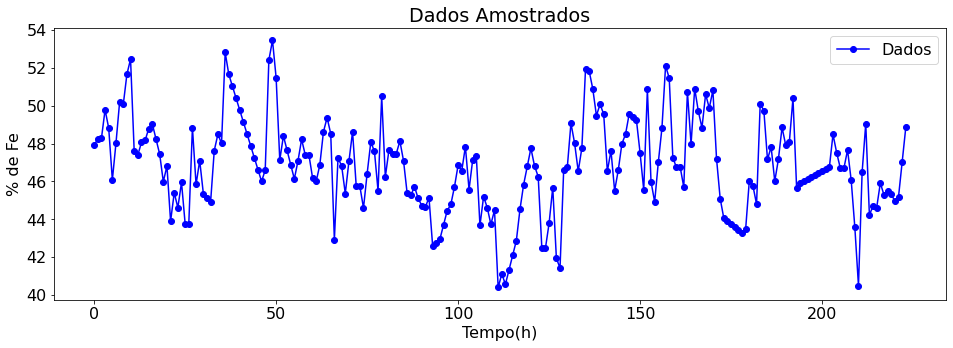

In [9]:
# visualiza os dados importados

fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = [16, 5])
plt.plot(dados, color = 'blue', label = 'Dados', marker = "o")
plt.title('Dados Amostrados')
plt.xlabel('Tempo(h)')
plt.ylabel('% de Fe')
plt.legend()
plt.savefig('dados_gerais_Fe.eps', format = 'eps', bbox_inches = 'tight')
plt.show()

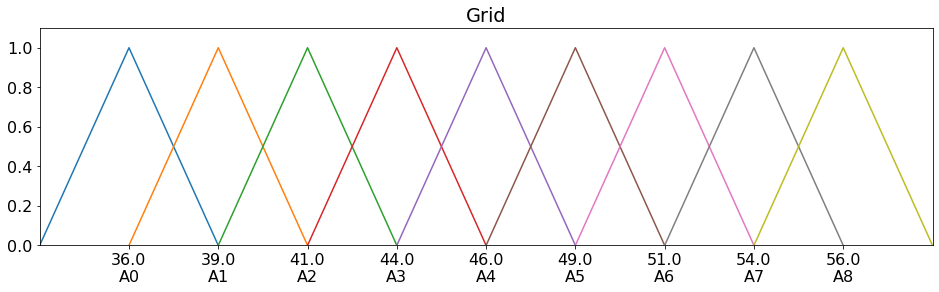

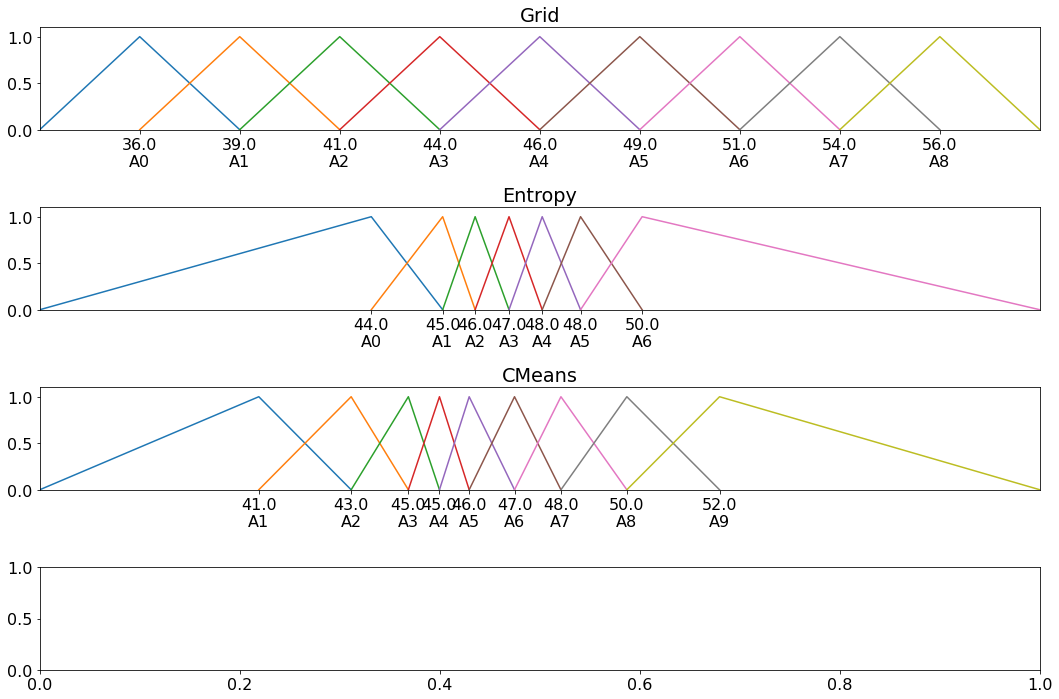

In [11]:
# particiona os dados
# Grid.GridPartitioner, Entropy.EntropyPartitioner, FCM.FCMPartitioner,CMeans.CMeansPartitioner
# Particionamento do Universo de Discurso
# data -> recebe os dados que serao usados no particionador
# npart -> numero de particoes que os dados serao divididos
# func -> funcao de pertinencia
# Membership.trimf, Membership.trapmf, Membership.gaussmf]
particionador = Grid.GridPartitioner(data = dados_treino, npart = 9, func =Membership.trimf)

# plota como os dados ficaram particionados
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16, 4])
particionador.plot(ax)
# plotar os tipos de particionadores somente
metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner,  CMeans.CMeansPartitioner]
#FCM.FCMPartitioner,
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=[15, 10])

for contador, metodo in enumerate(metodos):
  particionador = metodo(data = dados_treino, npart = 9)
  particionador.plot(ax[contador])

plt.tight_layout()
plt.savefig('metodos_part_FTS.eps', format = 'eps', bbox_inches = 'tight')


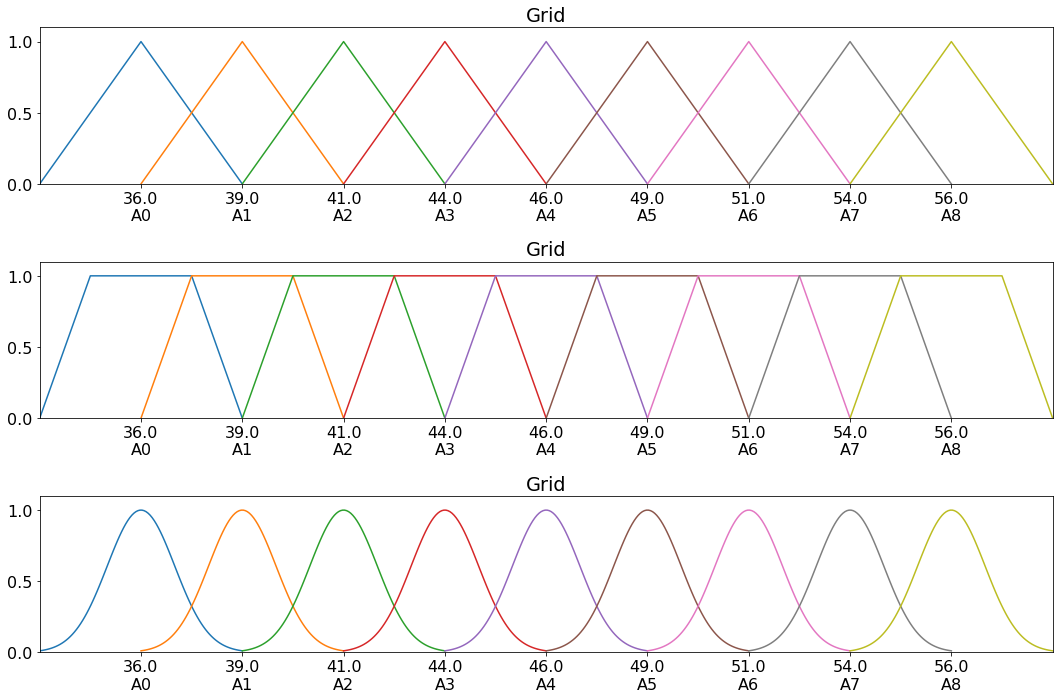

In [12]:
# plota apenas as funcoes de pertinencia

functions = [Membership.trimf, Membership.trapmf, Membership.gaussmf]

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = [15, 10])

for contador, mf in enumerate(functions):
  particionador = Grid.GridPartitioner(data = dados_treino, npart = 9,func = mf)
  particionador.plot(ax[contador])
plt.tight_layout()
plt.savefig('func_pert_FTS.eps', format = 'eps', bbox_inches = 'tight')

In [13]:
# Cria um modelo vazio
modelo = hofts.HighOrderFTS(partitioner = particionador, order = ordem)
#modelo = hofts.WeightedHighOrderFTS(partitioner = particionador, order =ordem)
#modelo = pwfts.ProbabilisticWeightedFTS(partitioner = particionador, order= ordem)



# Todo o procedimento de treinamento e feito pelo metodo fit
modelo.fit(dados_treino)

# Todo o procedimento de inferencia e feito pelo metodo predict
predicoes = modelo.predict(dados_teste)

# insere um espaco vazio no vetor para se encaixar melhor nos graficos
for k in range(modelo.order):
  predicoes.insert(0, None)

In [14]:
# metricas

rows = []
rmse = []
mape = []
u = []
rmse, mape, u = Measures.get_point_statistics(dados_teste, modelo)

rows.append([ rmse, mape, u])

tts1 = list(range(len(dados_treino) - ordem, len(dados_treino) + len(dados_teste)- ordem))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


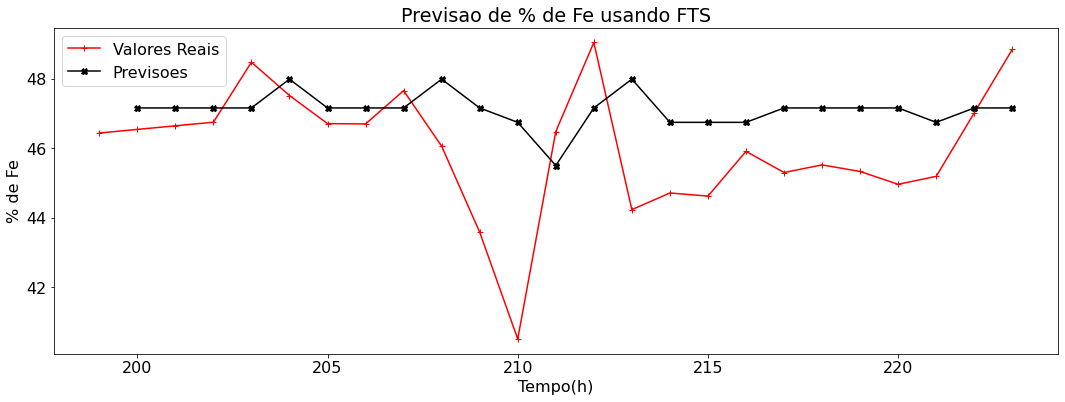

,RMSE,MAPE,U
0,2.11,3.64,1.03


In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [18, 6])
plt.plot(tts, dados_teste, color = 'red', label = 'Valores Reais', marker ="+")
plt.plot(tts1, predicoes, color = 'black', label = 'Previsoes', marker = "X")
plt.title('Previsao de % de Fe usando FTS')
plt.xlabel('Tempo(h)')
plt.ylabel('% de Fe')
plt.legend()
plt.savefig('prev_FTS_Fe.eps', format = 'eps', bbox_inches='tight')
plt.show()

pd.DataFrame(rows, columns=['RMSE', 'MAPE', 'U'])